In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

from train_util import *
from SimCLR import *
from resnet50 import *
import numpy as np
import time
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


# SimCLR Training

In [ ]:
#useful constants
device = 'cuda' if torch.cuda.is_available() else 'cpu'
projection_dim = 2048
batch_size = 128
log_every_n = 50
weight_decay = 1e-6
epochs = 50

In [ ]:
#create training  process
def train(train_loader, model, criterion, optimizer, scheduler):
    loss_epoch = 0
    global_steps = 0
    start = time.time()
    for step, ((x_i, x_j), _) in enumerate(train_loader):
        optimizer.zero_grad()
        x_i = x_i.cuda(non_blocking=True)
        x_j = x_j.cuda(non_blocking=True)

        # output pairs, before and after projection head
        h_i, h_j, z_i, z_j = model(x_i, x_j)

        loss = criterion(z_i, z_j)
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        global_steps += 1

        if global_steps % log_every_n == 0:
            end = time.time()
            num_examples_per_second = log_every_n * batch_size / (end - start)
            print("[Step=%d]\tLoss=%.4f\t%.1f examples/second"
                  % (global_steps, loss_epoch / (step + 1), num_examples_per_second))
            start = time.time()

    return loss_epoch/ (step + 1)


In [ ]:
# load training, test datasets
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    download=True,
    train=True,
    transform=TransformsSimCLR(),
)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True,drop_last=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
#initalize resnet
encoder = ResNet50()
encoder = encoder.to(device)
n_features = encoder.fc.in_features
#initalize model with projection head
model = SimCLR(encoder, projection_dim, n_features)
model = model.to(device)
#initialize LARS
learning_rate = 0.2
optimizer = LARS(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)
#initialize schedulers
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.01, last_epoch=-1)

criterion = SimCLR_Loss(batch_size = batch_size, temperature = 0.5)

In [ ]:
model_checkpoint = "CLModel_001"
best_loss = 100
lossdata = np.zeros(epochs)
optimizer.param_groups[0]["lr"] = 0.01
for epoch in range(epochs):
    loss_epoch  = train(trainloader, model, criterion, optimizer, scheduler)
    lossdata[epoch] = loss_epoch
    if epoch <10:
        warmupscheduler.step()
    else:
        scheduler.step()
        
    if loss_epoch <best_loss:
        torch.save(model.state_dict(), model_checkpoint)
        best_loss = loss_epoch

    epoch = epoch +1

[Step=50]	Loss=5.5236	107.1 examples/second
[Step=100]	Loss=5.5178	107.7 examples/second
[Step=150]	Loss=5.5155	107.9 examples/second
[Step=200]	Loss=5.5129	107.9 examples/second
[Step=250]	Loss=5.5107	108.0 examples/second
[Step=300]	Loss=5.5092	107.7 examples/second
[Step=350]	Loss=5.5065	107.8 examples/second
[Step=50]	Loss=5.4422	107.9 examples/second
[Step=100]	Loss=5.4058	108.0 examples/second
[Step=150]	Loss=5.3754	107.9 examples/second
[Step=200]	Loss=5.3502	107.9 examples/second
[Step=250]	Loss=5.3232	107.8 examples/second
[Step=300]	Loss=5.2954	107.9 examples/second
[Step=350]	Loss=5.2704	108.0 examples/second
[Step=50]	Loss=5.0569	107.7 examples/second
[Step=100]	Loss=5.0383	107.8 examples/second
[Step=150]	Loss=5.0218	107.9 examples/second
[Step=200]	Loss=5.0050	108.1 examples/second
[Step=250]	Loss=4.9877	108.2 examples/second
[Step=300]	Loss=4.9730	108.1 examples/second
[Step=350]	Loss=4.9630	108.4 examples/second
[Step=50]	Loss=4.8522	108.4 examples/second
[Step=100]	Los

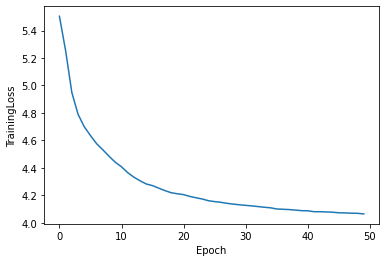

In [ ]:
#Training loss of SimCLR over the course of the first 50 epochs

import matplotlib.pyplot as plt
plt.plot(lossdata)
plt.xlabel("Epoch")
plt.ylabel("TrainingLoss")
plt.show()

# Sample Image Pairs

Files already downloaded and verified


<function matplotlib.pyplot.show>

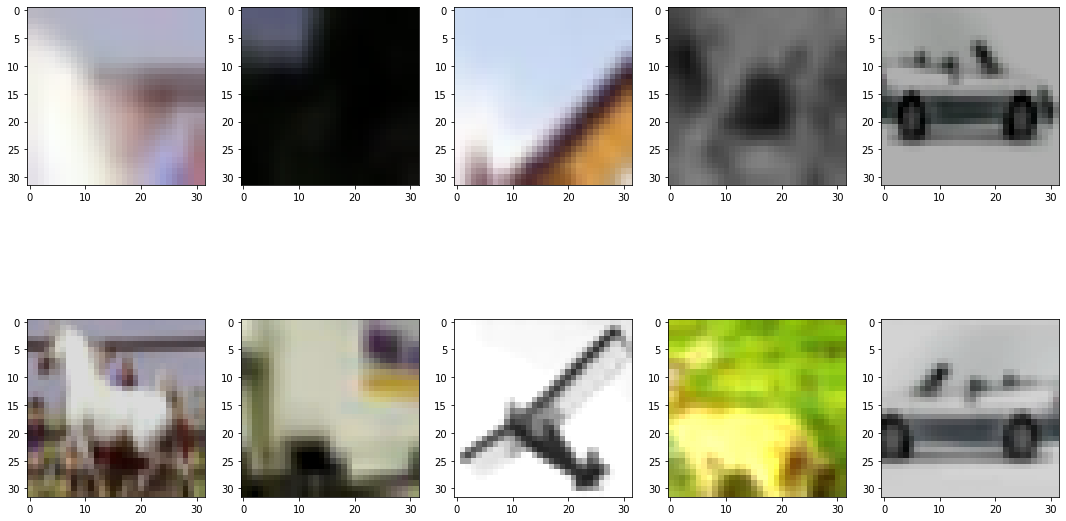

In [ ]:
#This is a small section just to view the output pairs that the augmentation in
#SimCLR generates
#Here we redefine the transform and dataloader just to avoid the ToTensor 
#command
import matplotlib.pyplot as plt

class TransformsView:
    def __init__(self, size = (32,32)):
        self.transform_train = transforms.Compose([
            transforms.RandomResizedCrop(size),
            transforms.RandomHorizontalFlip(),
            get_color_distortion(),
            transforms.ToTensor(),

        ])


    def __call__(self, x):
        return self.transform_train(x), self.transform_train(x)

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    download=True,
    train=True,
    transform=TransformsView(),
)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                          shuffle=True,drop_last=True)

def imshow(img,axarr,i):
    axarr[0,i].imshow(img[0].squeeze().permute(1, 2, 0))
    axarr[1,i].imshow(img[1].squeeze().permute(1, 2, 0))
    f.set_size_inches(18.5, 10.5)

f, axarr = plt.subplots(2,5)
for k in range(5):
  dataiter = iter(trainloader)
  images, labels = dataiter.next()
  imshow(images,axarr,k)
plt.show


# Finetuning

In [ ]:
#constants
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 10
projection_dim = 2048

In [ ]:
encoder = ResNet50()
encoder = encoder.to(device)
n_features = encoder.fc.in_features
#initalize model with projection head
model = SimCLR(encoder, projection_dim, n_features)
model = model.to(device)
model.load_state_dict(torch.load("CLModel_001"))
finetune = torch.nn.Sequential(*(list(model.children())[:-1]))
finetune.fc = nn.Linear(projection_dim,num_classes)
finetune = finetune.to(device)
for p in finetune.parameters():
    p.requires_grad = True
#to avoid fine tuning of features, set require grad before 

In [ ]:
#transforms, datasets, dataloaders
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

transform_train = transforms.Compose([
    transforms.RandomResizedCrop((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    download=True,
    train=True,
    transform=transform_train,
)

val_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    download=True,
    train = False,
    transform=transform_val,
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dsoptimizer = torch.optim.SGD([params for params in finetune.parameters() if params.requires_grad],lr = 0.003, momentum = 0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(dsoptimizer, step_size=1, gamma=1, last_epoch=-1)
loss_fn = nn.CrossEntropyLoss()

def finetunecyc(model, train_loader,loss_fn,dsoptimizer):
  train_loss =0
  val_loss = 0
  correct_examples = 0
  total_examples = 0
  for batch_idx, (inputs, targets) in enumerate(train_loader):
    ####################################
    train_features, train_labels = next(iter(train_loader))
    train_features, train_labels = train_features.to(device), train_labels.to(device)
    out = model(train_features)
    loss = loss_fn(out, train_labels)
    train_loss = train_loss + loss
    model.zero_grad()
    loss.backward()
    dsoptimizer.step()       
    
    correct = torch.sum(torch.eq(torch.argmax(out,dim=1),train_labels))
    correct_examples  = correct_examples + correct.item()
    total_examples = total_examples + train_labels.numel()
    ####################################
  lr_scheduler.step()
  avg_loss = train_loss / len(train_loader)
  avg_acc = correct_examples / total_examples
  print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

  model.eval()
  total_examples = 0
  correct_examples = 0
  
  val_loss = 0 
  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(val_loader):
          val_features, val_labels = next(iter(val_loader))
          val_features, val_labels = val_features.to(device), val_labels.to(device)

          out = model(val_features)
          loss = loss_fn(out, val_labels)
          val_loss = val_loss + loss

          
          correct = torch.sum(torch.eq(torch.argmax(out,dim=1),val_labels))
          correct_examples  = correct_examples + correct.item()
          total_examples = total_examples + val_labels.numel()
          ####################################

  avg_loss = val_loss / len(val_loader)
  avg_acc = correct_examples / total_examples
  print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
  return avg_acc
 

In [ ]:
#specify percentage of CIFAR-10 training data set to use for fine tuning
perc = 1
EPOCHS = 60
perc_acc = np.zeros(EPOCHS)

train_indices, val_indices = train_test_split(list(range(len(train_dataset.targets))), test_size=(100-perc)/100, stratify=train_dataset.targets)
tune_dataset = torch.utils.data.Subset(train_dataset, train_indices)
tune_data_loader = torch.utils.data.DataLoader(tune_dataset, batch_size=100, shuffle=True)

best_val_acc = 0
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
  finetune.train()

    
  print("Epoch %d:" %i)
  total_examples = 0
  correct_examples = 0
  perc_acc[i] = finetunecyc(finetune, tune_data_loader,loss_fn,dsoptimizer)

print("="*50)
print(f"==> Optimization finished!")
perc30_acc = perc_acc

==> Training starts!
Epoch 0:
Training loss: 2.0934, Training accuracy: 0.2360
Validation loss: 1.4958, Validation accuracy: 0.4851
Epoch 1:
Training loss: 1.3202, Training accuracy: 0.5440
Validation loss: 1.1176, Validation accuracy: 0.5890
Epoch 2:
Training loss: 1.0778, Training accuracy: 0.6260
Validation loss: 1.1218, Validation accuracy: 0.6057
Epoch 3:
Training loss: 1.1645, Training accuracy: 0.5840
Validation loss: 1.0509, Validation accuracy: 0.6270
Epoch 4:
Training loss: 1.1884, Training accuracy: 0.5860
Validation loss: 1.2932, Validation accuracy: 0.5957
Epoch 5:
Training loss: 1.1640, Training accuracy: 0.6100
Validation loss: 1.2092, Validation accuracy: 0.5938
Epoch 6:
Training loss: 1.0515, Training accuracy: 0.6500
Validation loss: 1.1774, Validation accuracy: 0.6133
Epoch 7:
Training loss: 1.0842, Training accuracy: 0.6040
Validation loss: 1.3752, Validation accuracy: 0.5739
Epoch 8:
Training loss: 0.9583, Training accuracy: 0.6380
Validation loss: 1.1944, Validati

In [ ]:
correct_examples = 0
total_examples = 0
finetune.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        val_features, val_labels = next(iter(val_loader))
        val_features, val_labels = val_features.to(device), val_labels.to(device)


        
        out = finetune(val_features)
        loss = loss_fn(out, val_labels)

        correct = torch.sum(torch.eq(torch.argmax(out,dim=1),val_labels))
        correct_examples  = correct_examples + correct.item()
        total_examples = total_examples + val_labels.numel()
        ####################################

avg_acc = correct_examples / total_examples
print("Validation accuracy: %.4f" % ( avg_acc))


Validation accuracy: 0.6310


# Transfer Learning on CIFAR-100

In [ ]:
#constants
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 100
projection_dim = 2048

In [ ]:
encoder = ResNet50()
encoder = encoder.to(device)
n_features = encoder.fc.in_features
#initalize model with projection head
model = SimCLR(encoder, projection_dim, n_features)
model = model.to(device)
model.load_state_dict(torch.load("CLModel_001"))
for p in model.parameters():
  p.requires_grad = False
finetune = torch.nn.Sequential(*(list(model.children())[:-1]))
finetune.fc = nn.Linear(projection_dim,num_classes)
finetune = finetune.to(device)

In [ ]:
#transforms, datasets, dataloaders
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

transform_train = transforms.Compose([
    transforms.RandomResizedCrop((32,32)),
    transforms.ToTensor(),

])

transform_val = transforms.Compose([
    transforms.ToTensor(),

])

train_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    download=True,
    train=True,
    transform=transform_train,
)

val_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    download=True,
    train = False,
    transform=transform_val,
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dsoptimizer = torch.optim.SGD([params for params in finetune.parameters() if params.requires_grad],lr = 0.003, momentum = 0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(dsoptimizer, step_size=1, gamma=0.95, last_epoch=-1)
loss_fn = nn.CrossEntropyLoss()

def finetunecyc(model, train_loader,loss_fn,dsoptimizer):
  train_loss =0
  val_loss = 0
  correct_examples = 0
  total_examples = 0
  for batch_idx, (inputs, targets) in enumerate(train_loader):
    ####################################
    train_features, train_labels = next(iter(train_loader))
    train_features, train_labels = train_features.to(device), train_labels.to(device)
    out = model(train_features)
    loss = loss_fn(out, train_labels)
    train_loss = train_loss + loss
    model.zero_grad()
    loss.backward()
    dsoptimizer.step()       
    
    correct = torch.sum(torch.eq(torch.argmax(out,dim=1),train_labels))
    correct_examples  = correct_examples + correct.item()
    total_examples = total_examples + train_labels.numel()
    ####################################
  lr_scheduler.step()
  avg_loss = train_loss / len(train_loader)
  avg_acc = correct_examples / total_examples
  print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

  model.eval()
  total_examples = 0
  correct_examples = 0
  
  val_loss = 0 
  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(val_loader):
          val_features, val_labels = next(iter(val_loader))
          val_features, val_labels = val_features.to(device), val_labels.to(device)

          out = model(val_features)
          loss = loss_fn(out, val_labels)
          val_loss = val_loss + loss

          
          correct = torch.sum(torch.eq(torch.argmax(out,dim=1),val_labels))
          correct_examples  = correct_examples + correct.item()
          total_examples = total_examples + val_labels.numel()
          ####################################

  avg_loss = val_loss / len(val_loader)
  avg_acc = correct_examples / total_examples
  print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
  return avg_acc
 

In [ ]:
EPOCHS = 30
perc_acc = np.zeros(EPOCHS)


best_val_acc = 0
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
  finetune.train()
    
  print("Epoch %d:" %i)
  total_examples = 0
  correct_examples = 0
  perc_acc[i] = finetunecyc(finetune, train_loader,loss_fn,dsoptimizer)

print("="*50)
print(f"==> Optimization finished!")

==> Training starts!
Epoch 0:
Training loss: 3.5260, Training accuracy: 0.1703
Validation loss: 3.1984, Validation accuracy: 0.2194
Epoch 1:
Training loss: 3.2358, Training accuracy: 0.2186
Validation loss: 2.9818, Validation accuracy: 0.2583
Epoch 2:
Training loss: 3.1310, Training accuracy: 0.2380
Validation loss: 2.9152, Validation accuracy: 0.2867
Epoch 3:
Training loss: 3.0345, Training accuracy: 0.2557
Validation loss: 2.8994, Validation accuracy: 0.2834
Epoch 4:
Training loss: 2.9931, Training accuracy: 0.2687
Validation loss: 2.7894, Validation accuracy: 0.3067
Epoch 5:
Training loss: 2.9478, Training accuracy: 0.2771
Validation loss: 2.7948, Validation accuracy: 0.3011
Epoch 6:
Training loss: 2.8966, Training accuracy: 0.2872
Validation loss: 2.7182, Validation accuracy: 0.3192
Epoch 7:
Training loss: 2.8652, Training accuracy: 0.2926
Validation loss: 2.7664, Validation accuracy: 0.3044
Epoch 8:
Training loss: 2.8701, Training accuracy: 0.2895
Validation loss: 2.6966, Validati

In [ ]:
correct_examples = 0
total_examples = 0
finetune.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        val_features, val_labels = next(iter(val_loader))
        val_features, val_labels = val_features.to(device), val_labels.to(device)


        
        out = finetune(val_features)
        loss = loss_fn(out, val_labels)

        
        correct = torch.sum(torch.eq(torch.argmax(out,dim=1),val_labels))
        correct_examples  = correct_examples + correct.item()
        total_examples = total_examples + val_labels.numel()
        ####################################

avg_acc = correct_examples / total_examples
print("Validation accuracy: %.4f" % ( avg_acc))


Validation accuracy: 0.3717
